In [2]:
import os
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/valid'

#classes to be used
classes = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
           'olympic wrestling', 'rugby', 'canoe slalom', 'roller derby', 'high jump',
           'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
           'rings', 'swimming', 'uneven bars', 'figure skating pairs']

Num GPUs Available:  0


In [6]:
import math

def load_data(data_dir, batch_size, img_size):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    data_flow = datagen.flow_from_directory(
        data_dir,
        class_mode="categorical",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        classes=classes
    )
    
    dataset = tf.data.Dataset.from_generator(
        lambda: data_flow,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *img_size, 3], [None, len(classes)])
    )
    
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE), math.ceil(data_flow.samples / batch_size)

In [7]:
img_size = (180, 180)
batch_size = 64

train_dataset, steps_per_epoch = load_data(train_dir, batch_size=batch_size, img_size=img_size)
val_dataset, validation_steps = load_data(val_dir, batch_size=batch_size, img_size=img_size)
test_dataset, test_steps = load_data(test_dir, batch_size=batch_size, img_size=img_size)

Found 3147 images belonging to 20 classes.
Found 95 images belonging to 20 classes.
Found 95 images belonging to 20 classes.


<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;">
<strong><centre>Model Training</centre></strong></h1>

### custom_cnn_it_06_03_01

----

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(180, 180, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(512, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(1024, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    elif epoch < 25:
        return lr * 0.85
    else:
        return lr * 0.75

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_it_06_03_01.keras',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 2, 2, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 2, 2, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,366,356 (28.10 MB)

 Trainable params: 7,362,324 (28.09 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [19]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - accuracy: 0.1511 - loss: 8.7119 - val_accuracy: 0.0421 - val_loss: 7.6441 - learning_rate: 5.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 586ms/step - accuracy: 0.2833 - loss: 6.7779 - val_accuracy: 0.1263 - val_loss: 6.8923 - learning_rate: 5.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 683ms/step - accuracy: 0.3322 - loss: 5.9240 - val_accuracy: 0.2632 - val_loss: 5.6884 - learning_rate: 5.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 645ms/step - accuracy: 0.3698 - loss: 5.2733 - val_accuracy: 0.2842 - val_loss: 5.1920 - learning_rate: 5.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 688ms/step - accuracy: 0.4198 - loss: 4.6682 - val_accuracy: 0.4211 - val_loss: 4.5663 - learning_rate: 5.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 637ms/step - accuracy: 0.4464 - loss: 4.2258 - val_accuracy: 0.5368 - val_loss: 3.7126 - learning_rate: 5.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 611ms/step - acc

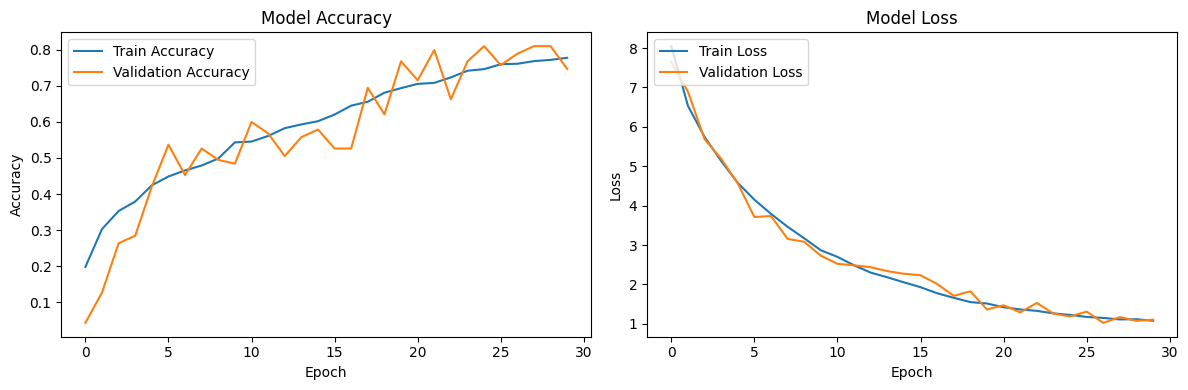

In [20]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [21]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")
model.save('final_model_it_06_03_01.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7448 - loss: 1.2937
Test accuracy: 75.79%
Test loss: 1.2650
